<a href="https://githubtocolab.com/borislevant/python4cv/blob/main/basic_image_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Edge detection: from gradients to Canny filter
## by Dr. Boris Levant

[![scikit-learn logo](./img/opencv-logo-small.png)](https://docs.opencv.org/3.4/d0/de3/tutorial_py_intro.html)

Edge detection includes a variety of mathematical methods that aim at identifying edges, curves in a digital image at which the image brightness changes sharply or, more formally, has discontinuities. The purpose of detecting sharp changes in image brightness is to capture important events and changes in properties of the world. It can be shown that under rather general assumptions for an image formation model, discontinuities in image brightness are likely to correspond to:
* discontinuities in depth
* discontinuities in surface orientation
* changes in material properties
* variations in scene illumination

In the ideal case, the result of applying an edge detector to an image may lead to a set of connected curves that indicate the boundaries of objects, the boundaries of surface markings as well as curves that correspond to discontinuities in surface orientation. Thus, applying an edge detection algorithm to an image may significantly reduce the amount of data to be processed and may therefore filter out information that may be regarded as less relevant, while preserving the important structural properties of an image. If the edge detection step is successful, the subsequent task of interpreting the information contents in the original image may therefore be substantially simplified. However, it is not always possible to obtain such ideal edges from real life images of moderate complexity.



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Simple gradients of the image

Let's first create the simplest possible image to try the simplest filters - gradients. We can use the OpenCV functions to draw the different shapes. In general, OpenCV has a number of drawing functions you can use to draw various shapes, including polygons of irregular shapes, but the three most common OpenCV drawing functions you will see are:

* cv2.line: Draws a line on image, starting at a specified (x, y)-coordinate and ending at another (x, y)-coordinate
* cv2.circle: Draws a circle on an image specified by the center (x, y)-coordinate and a supplied radius
* cv2.rectangle: Draws a rectangle on an image specified by the top-left corner and bottom-right corner (x, y)-coordinates
* cv2.ellipse: Draws an ellipse on an image
* cv2.polylines: Draws the outline of a polygon specified by a set of (x, y)-coordinates
* cv2.fillPoly: Draws a polygon, but instead of drawing the outline, instead fills in the polygon
* cv2.arrowedLine: Draws an arrow pointing from a starting (x, y)-coordinate to an ending (x, y)-coordinate

These OpenCV drawing functions are used less often but are still worth noting. One can look in this tutorial for more informatio:
https://pyimagesearch.com/2021/01/27/drawing-with-opencv/

The following code creates the clean image with a few geometric figures. Please, take a few minutes to play with it and understand the possibilities


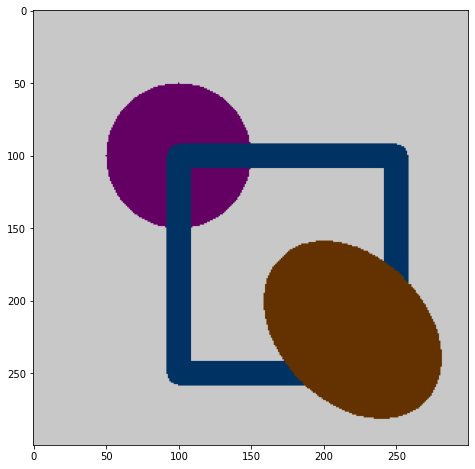

In [32]:
img_rect = np.zeros((300, 300, 3)).astype(np.uint8)+200
cv2.circle(img_rect, center=(100, 100), radius=50, color=(100, 0, 100), thickness=-1)
cv2.rectangle(img_rect, pt1=(100, 100), pt2=(250, 250), color=(0, 50, 100), thickness=15)
cv2.ellipse(img_rect, center=(220, 220), axes=(70, 50), 
            angle=45, startAngle=0, endAngle=360, color=(100, 50, 0), thickness=-1)

plt.figure(figsize=(8, 8))
plt.imshow(img_rect)

Let's create the simplest possible edge detection. For that we will use the following algorithm:
1. Turn the image into grayscale
2. Compute the derivatives of the image $G_x = \frac{\partial}{\partial x}$ and $G_y = \frac{\partial}{\partial y}$ in the direction x and y using the function ```diff``` of the ```numpy```
3. Compute the gradient of the image
$$
G(I) = \sqrt{G_x^2(I) + G_y^2(I)}
$$
4. In addition we would like to compute the orientation of the gradient
$$
\theta(I) = \arctan(G_y, G_x) \cdot(\frac{180}{\pi})
$$

In [98]:
def gradient_simple(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = np.diff(img_gray, axis=1, append=0)
    grad_y = np.diff(img_gray, axis=0, append=0)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad_orient = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180
    return img_gray, grad_x, grad_y, grad, grad_orient

def show_gradients(img, img_gray, grad_x, grad_y, grad, grad_orient):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original Image')
    ax[0, 1].imshow(img_gray, cmap='gray')
    ax[0, 1].set_title('Gray Image')
    ax[1, 0].imshow(grad_x, cmap='gray')
    ax[1, 0].set_title('Gradient in direction X')
    ax[1, 1].imshow(grad_y, cmap='gray')
    ax[1, 1].set_title('Gradient in direction Y')
    ax[2, 0].imshow(grad, cmap='jet')
    ax[2, 0].set_title('Magnitude of the Gradient')
    ax[2, 1].imshow(grad_orient, cmap='jet')
    ax[2, 1].set_title('Orientation of the Gradient')
    plt.show()


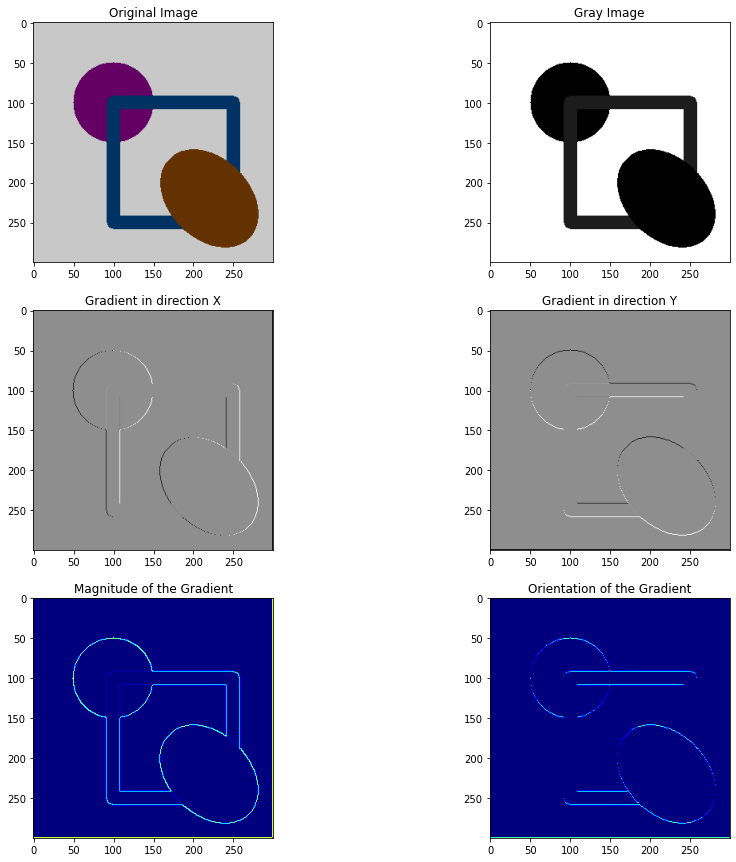

In [51]:
img_gray, grad_x, grad_y, grad, grad_orient = gradient_simple(img_rect)
show_gradients(img_rect, img_gray, grad_x, grad_y, grad, grad_orient)


This simplest possible implementation of the Edge detector - Magnitude of the gradient - has a few important drawbacks. It's very sensitive to the noise. Therefore, we have to add something more sofisticated

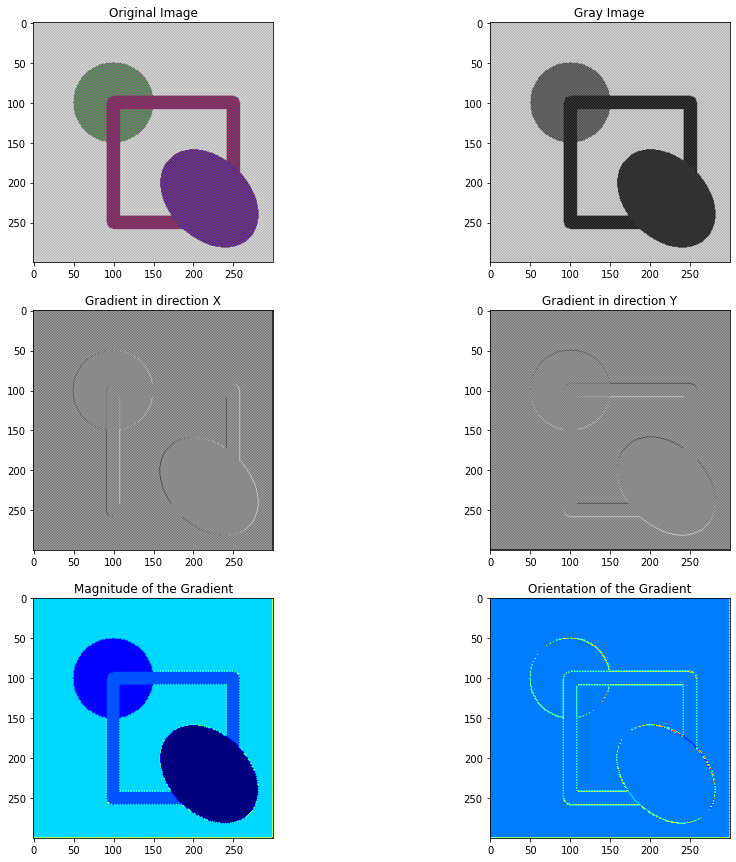

In [99]:
noise = np.zeros(img_rect.shape).astype(np.int8)
for i in range(img_rect.shape[0]):
    for j in range(img_rect.shape[1]):
        if (i%2) ^ (j%2):
            noise[i, j, :] = -1
        else:
            noise[i, j, :] = 1

img_gray, grad_x, grad_y, grad, grad_orient = gradient_simple((img_rect + 50*noise).astype(np.uint8))
show_gradients((img_rect + 50*noise).astype(np.uint8), img_gray, grad_x, grad_y, grad, grad_orient)

## Effects of noise and Sobel filter

The previous approach is simple, elegant and works great on the synthetic examples, but it fails with the very simple noise. Therefore, we need to fix it. To do it we use the ```Sobel``` filter which can be described as follows. The filter to compute the gradient in the x direction is combined from the 2 parts: *smoothing* and *centralized derivative*:

![gradient_x](./img/sobel_x.png)

The Gradient in the y direction looks very similar:

![gradient_y](./img/sobel_y.png)

Let's write the new Sobel-filter edge detection and check it on the previous example:


In [160]:
def gradient_sobel(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    grad_y = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
    grad = cv2.magnitude(grad_x, grad_y)
    grad_orient = cv2.phase(np.array(grad_x, np.float32), np.array(grad_y, dtype=np.float32), angleInDegrees=True)
    return img_gray, grad_x, grad_y, grad, grad_orient


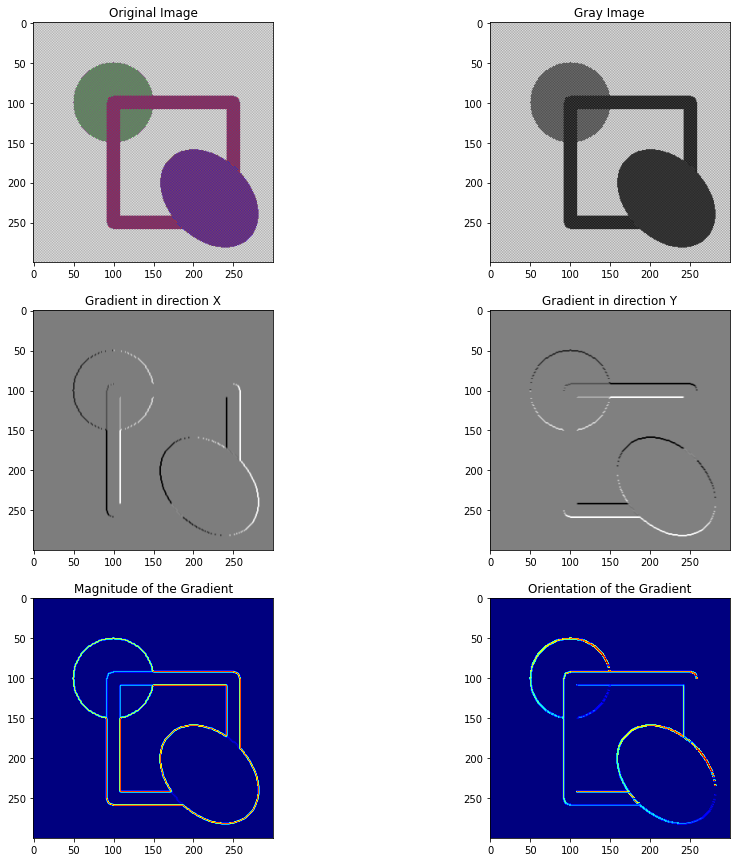

In [161]:
img_gray, grad_x, grad_y, grad, grad_orient = gradient_sobel((img_rect + 50*noise).astype(np.uint8))
show_gradients((img_rect + 50*noise).astype(np.uint8), img_gray, grad_x, grad_y, grad, grad_orient)


We see that the Sobel filer overcome the noise problem we intorudced in the previous part. Let's see how it works on the real world examples

In [106]:
img_dog = cv2.imread('img/cute_dog_small.jpg', cv2.IMREAD_COLOR)
imhead = img_dog[100:200, 150:300, :].copy()

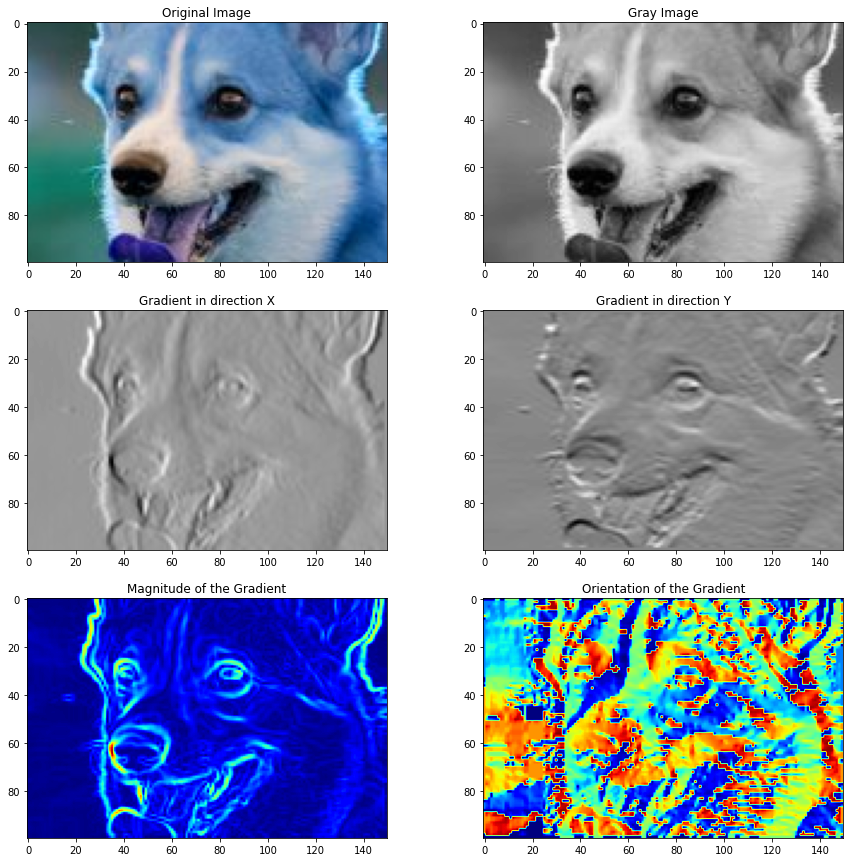

In [162]:
img_gray, grad_x, grad_y, grad, grad_orient = gradient_sobel(imhead)
show_gradients(imhead, img_gray, grad_x, grad_y, grad, grad_orient)


## Canny filter

Still we observe that the filter doesn't work perfect. We still observe weak edges, that we might want to drop. Let's introduce the new filter - ```Canny```. Let’s discuss the actual Canny edge detection algorithm, which is a multi-step process consisting of:

1. Applying Gaussian smoothing to the image to help reduce noise
2. Computing the $G_{x}$ and $G_{y}$ image gradients using the Sobel kernel
3. Applying non-maxima suppression to keep only the local maxima of gradient magnitude pixels that are pointing in the direction of the gradient
4. Defining and applying the $T_\text{upper}$ and $T_\text{lower}$ thresholds for Hysteresis thresholding


In [174]:
def gradient_canny(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(img_gray, 80, 200)
    return img_gray, edge


Text(0.5, 1.0, 'Gray Image')

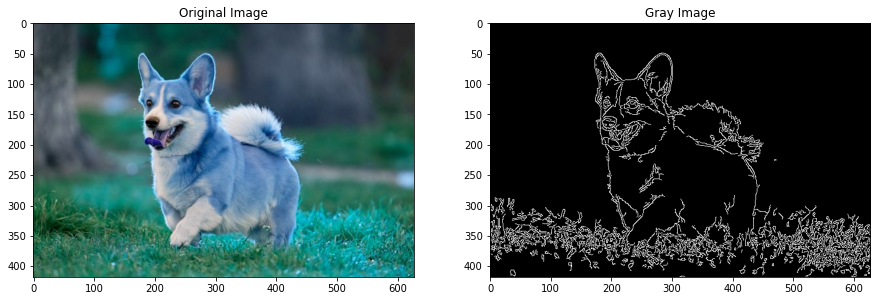

In [175]:
img_gray, edge = gradient_canny(img_dog)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(img_dog)
ax[0].set_title('Original Image')
ax[1].imshow(edge, cmap='gray')
ax[1].set_title('Gray Image')


## Detecting the lines: Hough transform

In [22]:
img = cv2.imread('img/cute_dog_small.jpg', cv2.IMREAD_GRAYSCALE)
print(f'The shape of the img object is {img.shape}')
print(f'The type of the img object is {img.dtype}')

The shape of the img object is (418, 627)
The type of the img object is uint8


Next we would like to display the image in the notebook. We will use the ```Matplotlib``` function ```imshow```. Displaying the grayscale images in addition to the image itself, requires to specify the color map in which we want to show the image. Below we will use a few examples. Please, try to experiment with different values of the color maps, as found in the ```Matplotlib``` tutorial: https://matplotlib.org/stable/tutorials/colors/colormaps.html


Text(0.5, 1.0, 'plasma')

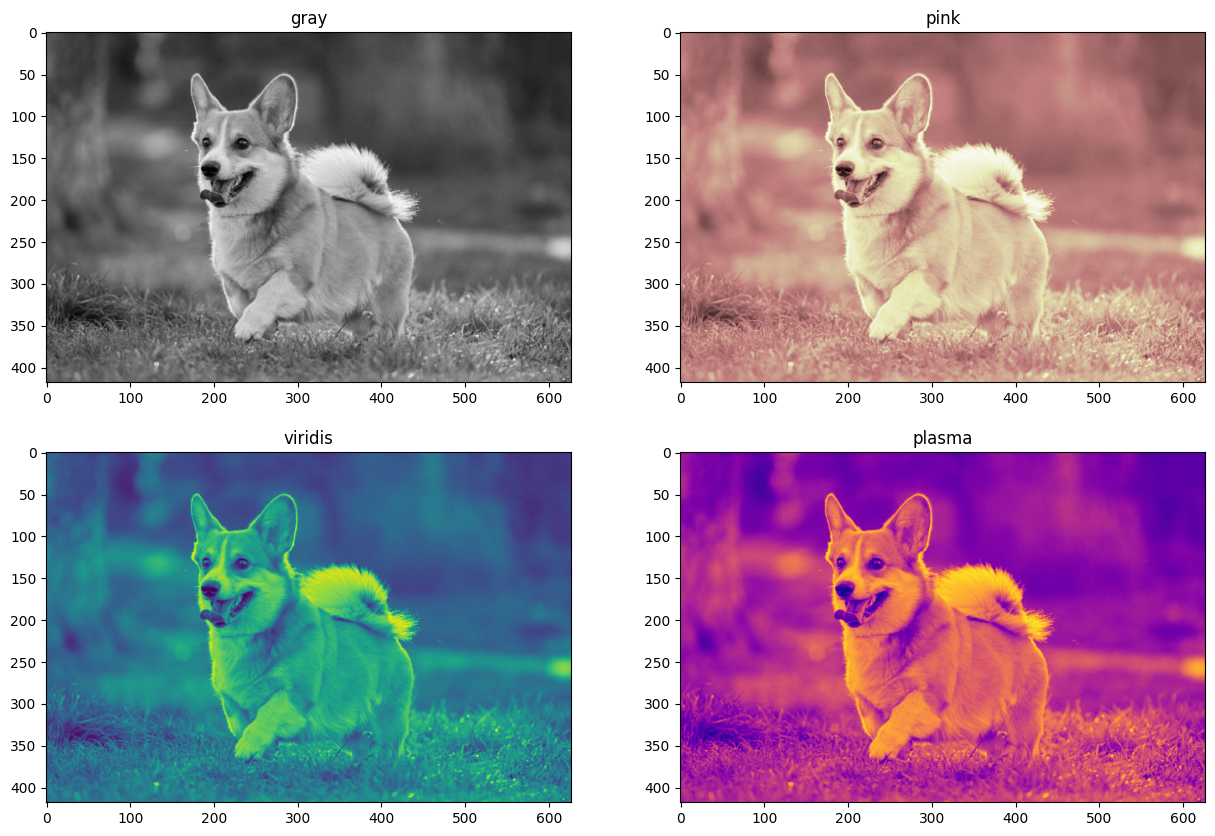

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('gray')
ax[0, 1].imshow(img, cmap='pink')
ax[0, 1].set_title('pink')
ax[1, 0].imshow(img, cmap='viridis')
ax[1, 0].set_title('viridis')
ax[1, 1].imshow(img, cmap='plasma')
ax[1, 1].set_title('plasma')


Now let's read the image as a color. This time we see that the image is a 3D array - third dimension represents the color

In [21]:
imgc = cv2.imread('img/cute_dog_small.jpg', cv2.IMREAD_COLOR)
print(f'The shape of the img object is {imgc.shape}')

The shape of the img object is (418, 627, 3)


By default, the OpenCV images are stored in the BGR format - Blue, Green and Red. In order to convert them to the more familiar RGB, we need to use the function ```cvtColor```. It is used to convert between different color spaces and we will use it in the future

In order to show examples we will implement the following function that will show the pairs of the images

In [36]:
def imshow_filters(im, filter_func, name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax[0].imshow(im)
    ax[0].set_title('Original Image')
    ax[1].imshow(filter_func(im))
    ax[1].set_title(name)
    plt.show()


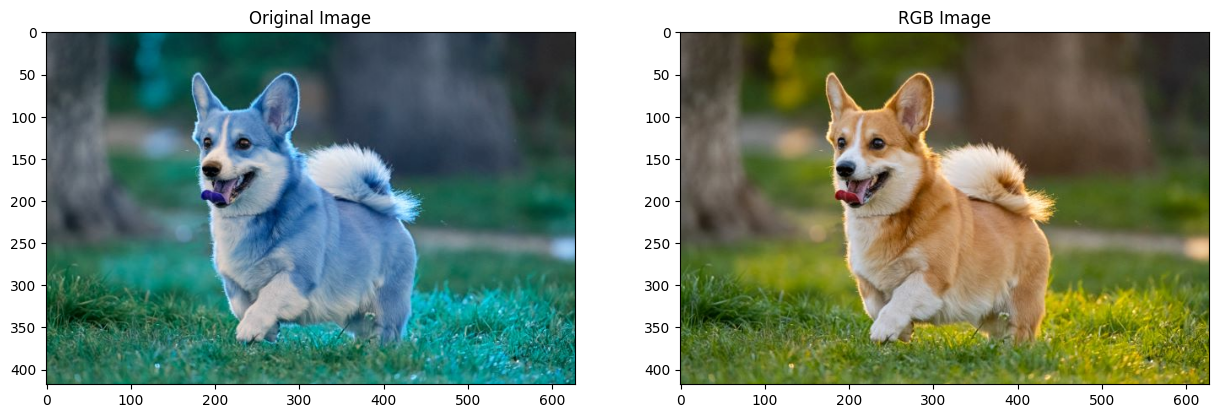

In [37]:
imshow_filters(imgc, lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), 'RGB Image')

In order to save the image we use the function ```imwrite``` accepting the filename and the image itself. The format of the image to be saved is determined by the extension of the file name: jpg, png, tiff, etc. The function returns the status of the operation: True/False


In [38]:
status = cv2.imwrite('img/cute_dog_gray.jpg', img)
print(f'The operation was successfull?: {status}')


The operation was successfull?: True


## Smoothing


Image smoothing is an image processing technique used for removing the noise in an image.Blurring(smoothing) removes low-intensity edges and is also beneficial in hiding the details; for example, blurring is required in many cases, such as hiding any confidential information in an image.OpenCV provides mainly the following type of blurring techniques.

Here are a few of the methods that we are going to use for smoothing an image:

* OpenCV averaging
* OpenCV median Blur
* OpenCV Gaussian Blur
* OpenCV Bilateral Filter


### Adding the noise to the image

In order to add the noise to the image we will use the 
Let's cut the portion of the image (the head of the dog) and add some noise to see how each filtering technique
* Clears the noise
* Affects the blurriness of the image

In order to create the Gaussian noise, we first create the noise of the size of the image

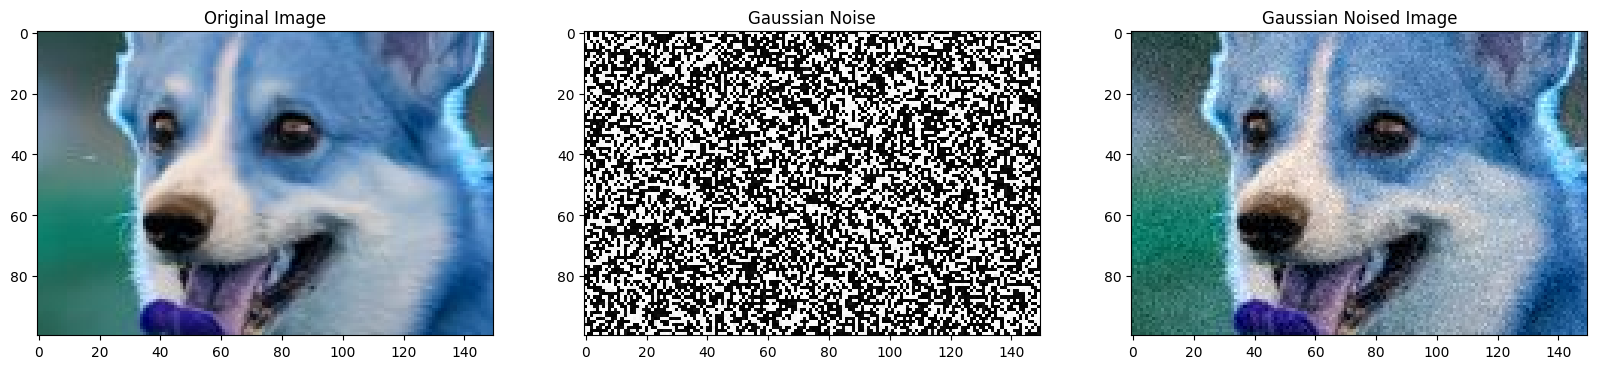

In [216]:
imhead = imgc[100:200, 150:300, :].copy()
gauss = np.random.normal(0, 10, imhead.shape[:2]).astype(np.float32)

imhead_noisy = imhead.astype(np.float32).copy()
imhead_noisy[:, :, 0] = imhead_noisy[:, :, 0] + gauss
imhead_noisy[:, :, 1] = imhead_noisy[:, :, 1] + gauss
imhead_noisy[:, :, 2] = imhead_noisy[:, :, 2] + gauss
imhead_noisy = np.clip(imhead_noisy, 0, 255).astype(np.uint8)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
ax[0].imshow(imhead)
ax[0].set_title('Original Image')
ax[1].imshow(gauss.astype(np.uint8), cmap='gray')
ax[1].set_title('Gaussian Noise')
ax[2].imshow(imhead_noisy)
ax[2].set_title('Gaussian Noised Image')
plt.show()


In [214]:
from ipywidgets import interact
import ipywidgets as widgets


### Average smoothing

In this technique, we normalize the image with a box filter. It calculates the average of all the pixels which are under the kernel area(box filter) and replaces the value of the pixel at the center of the box filter with the calculated average. OpenCV provides the cv2.blur() to perform this operation. 
$$
K = \frac{1}{H\cdot W} \left[ {\begin{array}{cccc}
    1 & 1 & \cdots & 1 \newline
    1 & 1 & \cdots & 1 \newline
    \vdots & \vdots & \ddots & \vdots \newline
    1 & 1 & \cdots & 1 \newline
  \end{array} } \right]
$$
while the size of the kernel is $H \times W$.

The syntax of cv2.blur() function is as follows
```
cv2.blur(src, ksize, anchor, borderType)
```

Parameters:

* *src*: It is the image which is to be blurred
* *ksize*: A tuple representing the blurring kernel size $H\times W$
* *anchor*: It is a variable of type integer representing anchor point and it’s default value Point is (-1, -1) which means that the anchor is at the kernel center
* *borderType*: It represents the type of border to be used for the output


In [225]:
def show_average_filter(ksize=5):
    imshow_filters(imhead_noisy, lambda x: cv2.blur(x, (ksize, ksize), borderType=cv2.BORDER_CONSTANT), f'Image Average Filter ({ksize}, {ksize})')
    
interact(show_average_filter, ksize=(1, 15, 2))

interactive(children=(IntSlider(value=5, description='ksize', max=15, min=1, step=2), Output()), _dom_classes=…

<function __main__.show_average_filter(ksize=5)>

### Gaussian filter

In this technique, a Gaussian function(kernel) instead of a box filter to blur the image. The width and height of the kernel needs to be specified and they should be positive and odd. We also have to specify the standard deviation in the directions X and Y and are represented by sigmaX and sigmaY respectively. If both sigmaX and sigmaY are given as zeros, they are calculated from the kernel size and if we only specify sigmaX, sigmaY is set to the same value. Gaussian blurring is highly effective when removing Gaussian noise from an image. In OpenCV we have a function GaussianBlur() to implement this technique easily. Here is the syntax:
```
GaussianBlur(src, ksize, sigmaX, sigmaY)
```

Parameters:

* src − Input image which is to be blurred
* ksize − A Size object representing the size of the kernel.
* sigmaX − A variable of the type double representing the Gaussian kernel standard deviation in X direction.
* sigmaY − A variable of the type double representing the Gaussian kernel standard deviation in Y direction.


In [226]:
def show_gaussian_filter(ksize=5):
    imshow_filters(imhead_noisy, lambda x: cv2.GaussianBlur(x, (ksize, ksize), 0, 0), f'Image Gaussian Filter of size {ksize}')
    
interact(show_gaussian_filter, ksize=(1, 15, 2))


interactive(children=(IntSlider(value=5, description='ksize', max=15, min=1, step=2), Output()), _dom_classes=…

<function __main__.show_gaussian_filter(ksize=5)>

### Median Blur

In this technique, the median of all the pixels under the kernel window is computed and the central pixel is replaced with this median value. It has one advantage over the Gaussian and box filters, that being the filtered value for the central element is always replaced by some pixel value in the image which is not the case in case of either Gaussian or box filters. OpenCV provides a function medianBlur() that can be used to easily implement this kind of smoothing. Here is the syntax:
```
cv2.medianBlur(src, dst, ksize)  
```

Parameters:

* src- It represents the source (input image).
* dst – It represents the destination (output image).
* ksize – It represents the size of the kernel.


In [223]:
def show_median_filter(ksize=5):
    imshow_filters(imhead_noisy, lambda x: cv2.medianBlur(x, ksize), f'Image Median Filter of size {ksize}')
    
interact(show_median_filter, ksize=(1, 15, 2))


interactive(children=(IntSlider(value=5, description='ksize', max=15, min=1, step=2), Output()), _dom_classes=…

<function __main__.show_median_filter(ksize=5)>

### Bilateral filter

This method of noise removal is highly effective but is slower compared to other filters. The Gaussian filter blurred the edges too and that is not what we want, but this filter makes sure that only those pixels with similar intensities to the central pixel are considered for blurring, thus preserving the edges since pixels at edges will have large intensity variation. In OpenCV we have cv.bilateralFilter() method that can implement this filter. Here is the syntax:
```
cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace, borderType)
```
A bilateral filter is a non-linear, edge-preserving, and noise-reducing smoothing filter for images. It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels. This weight can be based on a Gaussian distribution. Crucially, the weights depend not only on Euclidean distance of pixels, but also on the radiometric differences (e.g., range differences, such as color intensity, depth distance, etc.). This preserves sharp edges.

Parameters:

* src Source 8-bit or floating-point, 1-channel or 3-channel image.
* d Diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace.
* sigmaColor Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.
* sigmaSpace Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor ). When d>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace.
borderType border mode used to extrapolate pixels outside of the image, see the BorderTypes available here.


In [231]:
def show_bilateral_filter(ksize=5):
    imshow_filters(imhead_noisy, lambda x: cv2.bilateralFilter(x, ksize, 30, 30), f'Image Bilateral Filter of size {ksize}')
    
interact(show_bilateral_filter, ksize=(1, 15, 2))


interactive(children=(IntSlider(value=5, description='ksize', max=15, min=1, step=2), Output()), _dom_classes=…

<function __main__.show_bilateral_filter(ksize=5)>

## Upsampling

Usually when working on images, we often need to resize the images according to certain requirements. Mostly you will do such operation in Machine learning and deep learning as it reduces the time of training of a neural network. As the number of pixels in an image increases, the more is the number of input nodes that in turn increases the complexity of the model. We use an inbuilt resize() method to resize an image.

Syntax:
```
cv2.resize(s, size, fx, fy, interpolation)  
```

Parameters:

* s – input image (required).
* size – desired size for the output image after resizing (required)
* fx – Scale factor along the horizontal axis (optional)
* fy – Scale factor along the vertical axis (optional)

In order to resize we willl ned to interpolate the image using one of the following methods:
* INTER_NEAREST – a nearest-neighbor interpolation
* INTER_LINEAR – a bilinear interpolation (used by default) 
* INTER_AREA – resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
* INTER_CUBIC – a bicubic interpolation over 4×4 pixel neighborhood 
* INTER_LANCZOS4 – a Lanczos interpolation over 8×8 pixel neighborhood

Here is an example of how we can use this method:


In [169]:
imhead_double = cv2.resize(imhead, (0, 0), fx=3, fy=3, interpolation=cv2.INTER_LINEAR)
print(f'The size of the original image is {imhead.shape}, the new image is {imhead_double.shape}')


The size of the original image is (100, 150, 3), the new image is (300, 450, 3)


Let's observe the effect of the different interpolation methods on the final image quality

In [227]:
def show_upsampled_image(ratio=3, interpolation_method=cv2.INTER_LINEAR):
    img_upsampled = cv2.resize(imhead, (0, 0), fx=ratio, fy=ratio, interpolation=interpolation_method)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].imshow(imhead[50:80, 30:60, :])
    ax[0].set_title('Original Image croped nose')
    ax[1].imshow(img_upsampled[50*ratio:80*ratio, 30*ratio:60*ratio, :])
    ax[1].set_title('Upsampled Image croped nose')
    plt.show()

interact(show_upsampled_image, ratio=(1, 7, 1), interpolation_method=[('INTER_NEAREST', cv2.INTER_NEAREST), ('INTER_LINEAR', cv2.INTER_LINEAR), ('INTER_CUBIC', cv2.INTER_CUBIC)]);


interactive(children=(IntSlider(value=3, description='ratio', max=7, min=1), Dropdown(description='interpolati…

## Downsampling

We can use the ```resize``` method to do Downsampling. In this part we will try to do the Downsampling manually


In [228]:
def show_downsampled_image(ratio=3):
    img_downsampled = imhead[::ratio, ::ratio, :]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].imshow(imhead)
    ax[0].set_title('Original Image')
    ax[1].imshow(img_downsampled)
    ax[1].set_title('Downsampled Image')
    plt.show()

interact(show_downsampled_image, ratio=(1, 5));


interactive(children=(IntSlider(value=3, description='ratio', max=5, min=1), Output()), _dom_classes=('widget-…

We observe that Dwonsampling increases the noise. Let's try to use the de-noising techniques to improve the downsampled image quality

In [230]:
def show_downsampled_denoised_image(ratio=3, kernel_size=5):
    imhead_noisy_smooth = cv2.GaussianBlur(imhead, (kernel_size, kernel_size), 0, 0).copy()
    img_downsampled = imhead_noisy_smooth[::ratio, ::ratio, :]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].imshow(imhead)
    ax[0].set_title('Original Image')
    ax[1].imshow(img_downsampled)
    ax[1].set_title('Downsampled Image')
    plt.show()

interact(show_downsampled_denoised_image, ratio=(1, 5), kernel_size=(3, 7, 2));


interactive(children=(IntSlider(value=3, description='ratio', max=5, min=1), IntSlider(value=5, description='k…